In [31]:
%cd project/

[Errno 2] No such file or directory: 'project/'
/home/rapids/notebooks/project


In [17]:
import skmob
from skmob.utils import utils, constants
from skmob.tessellation import tilers
from skmob.utils.plot import plot_gdf

import numpy as np
import pandas as pd
import geopandas as gpd
from skmob.models.radiation import Radiation


from sklearn.model_selection import train_test_split
from random import sample
import pickle
from scipy.spatial import distance
import sys

from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (12, 9) # (w, h)

NameError: name 'data' is not defined

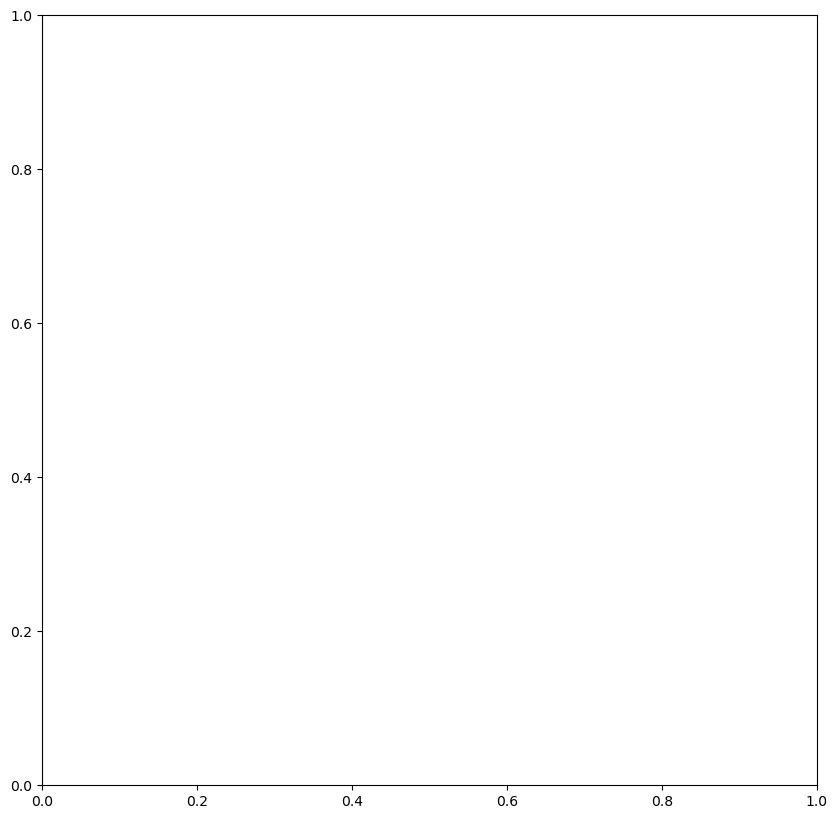

In [3]:
import contextily as ctx
# Visualizar geojson sobre un mapa base
fig, ax = plt.subplots(figsize=(10, 10))
data.plot(ax=ax, alpha=0.5, edgecolor='k')
ctx.add_basemap(ax, crs=data.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

plt.title("Tesselación de Buenos Aires")
plt.show()

UTILS

In [11]:
def toFdf(adj, tess, d):
    l = []
    for i in range(0,len(adj)):
        for j in range(0,len(adj)):
            if(adj[i,j]!=0):
                l.append([d[i],d[j], adj[i,j]])
    data = pd.DataFrame(l)
    return(data)

In [12]:
def toAdj(fdf, tess):
    names = list(tess.tile_ID.values)
    adj = pd.DataFrame(columns=names, index = names)
    for i, row in enumerate(fdf.itertuples(), 1):
         adj.at[str(row.origin), str(row.destination)] = row.flow
    return adj

TESSELLATION

In [13]:
shape_file_land = gpd.read_file("./barriosCABA.geojson")

meters = 2612.61
tessellation = tilers.tiler.get("squared", meters=meters, base_shape=shape_file_land)
plot_gdf(tessellation, style_func_args={'fillColor':'gray', 'color':'black', 'opacity': 0.2}, zoom = 9) 


/opt/conda/lib/python3.11/site-packages/skmob/tessellation/tilers.py:117: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  base_shape = gpd.GeoSeries(cascaded_union(polygons), crs=base_shape.crs)


DATA

In [14]:
with open("./generations/dia/v_train.txt", "rb") as fp:   # Unpickling
    v_train = pickle.load(fp)
print(len(v_train))


with open("./generations/dia/v_test.txt", "rb") as fp:   # Unpickling
    v_test = pickle.load(fp)
print(len(v_test))



a = list(enumerate(list(tessellation.tile_ID.values)))
d = dict(a)

tiles = np.asarray(list(d.values())).astype(int)
zeros = np.zeros(tiles.size)
lookup = dict(zip(tiles.astype(str), zeros))



1380
346


RADIATION

In [22]:
np.random.seed(0)
a = 0
l = []

for n in v_test:
    
    
    lookup = dict(zip(tiles.astype(str), zeros))
    lookup_pick = dict(zip(tiles.astype(str), zeros))

    flow = toFdf(n, tessellation, d)
    flow = flow[flow[0] != flow[1]]
    
    z = flow.groupby([0])[2].sum()
    for el in z.keys():
        lookup[el] += z[el]
    
    flow_pick = toFdf(n, tessellation, d)    
    z = flow_pick.groupby([0])[2].sum()
    for el in z.keys():
        lookup_pick[el] += z[el]
    
    tessellation['tot_outflow'] = tessellation['tile_ID'].map(lookup)
    tessellation['relevance'] = tessellation['tile_ID'].map(lookup_pick)
    tessellation['relevance'] = tessellation['relevance'] / (tessellation['relevance'].max())
    tessellation['relevance'] = tessellation['relevance'] + 0.00001
    
    fdf = skmob.FlowDataFrame(data = flow,tessellation=tessellation, tile_id='tile_ID', origin =0, 
                              destination = 1, flow = 2)
    
    radiation = Radiation()
    rad_flows = radiation.generate(tessellation, 
                tile_id_column='tile_ID', 
                tot_outflows_column='tot_outflow', 
                relevance_column= 'relevance', 
                out_format='flows')
    
    l.append(rad_flows)
    
    a+=1
    print(a)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 4615.78it/s]


1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 5216.19it/s]


2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 4907.68it/s]


3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 5087.76it/s]


4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 4547.83it/s]


5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 5657.23it/s]


6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 9998.71it/s]


7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 5559.17it/s]


8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 4753.09it/s]


9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 5514.51it/s]


10


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 4937.11it/s]


11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 4721.74it/s]


12


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 11194.61it/s]


13


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 11605.51it/s]


14


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 4585.50it/s]


15


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 9766.97it/s]


16


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 4561.12it/s]


17


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 4227.60it/s]


18


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 5717.23it/s]


19


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 4651.05it/s]


20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 4702.88it/s]


21


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 11029.03it/s]


22


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 4341.44it/s]


23


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 5497.46it/s]


24


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 10876.64it/s]


25


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 5948.44it/s]


26


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 4148.86it/s]


27


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 10362.30it/s]


28


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 5200.62it/s]


29


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 4361.47it/s]


30


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 5229.30it/s]


31


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 11314.93it/s]


32


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 8974.47it/s]


33


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 3394.18it/s]


34


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 4105.77it/s]

35



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 5819.87it/s]

36



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 4490.61it/s]


37


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 4652.99it/s]


38


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 4708.40it/s]


39


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 4183.71it/s]


40


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 676.36it/s]


41


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 4213.13it/s]


42


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 4288.65it/s]


43


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 4216.64it/s]


44


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 5155.38it/s]


45


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 4530.10it/s]


46


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 4831.28it/s]


47


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 5654.96it/s]


48


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 4571.84it/s]


49


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 4899.08it/s]


50


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 11226.44it/s]


51


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 4333.73it/s]


52


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 5807.90it/s]


53


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 4395.90it/s]


54


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 4547.83it/s]


55


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 4787.25it/s]


56


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 4908.67it/s]


57


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 4337.65it/s]


58


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 4507.81it/s]

59



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 5821.13it/s]


60


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 5045.02it/s]


61


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 5189.06it/s]


62


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 10844.12it/s]


63


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 5478.72it/s]


64


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 5278.76it/s]


65


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 4318.32it/s]


66


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 3971.00it/s]


67


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 4201.13it/s]


68


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 3858.55it/s]


69


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 4858.91it/s]


70


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 4572.85it/s]


71


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 4487.16it/s]


72


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 9725.22it/s]


73


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 4330.02it/s]


74


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 6053.62it/s]


75


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 4747.04it/s]


76


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 9130.77it/s]


77


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 4899.35it/s]


78


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 4561.20it/s]


79


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 11011.83it/s]


80


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 4839.29it/s]


81


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 6102.33it/s]

82



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 3759.02it/s]


83


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 5261.79it/s]


84


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 5678.29it/s]


85


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 5819.23it/s]


86


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 4257.43it/s]


87


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 12129.93it/s]


88


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 5021.24it/s]


89


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 5860.78it/s]


90


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 4402.67it/s]


91


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 4320.34it/s]


92


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 5629.23it/s]


93


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 10425.49it/s]


94


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 4538.37it/s]


95


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 4089.39it/s]


96


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 4416.15it/s]


97


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 11286.86it/s]


98


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 3878.96it/s]


99


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 4071.40it/s]


100


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 10704.45it/s]


101


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 9632.39it/s]


102


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 4874.79it/s]


103


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 10476.76it/s]


104


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 5084.68it/s]


105


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 4400.36it/s]


106


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 4680.82it/s]


107


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 4605.41it/s]


108


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 4729.56it/s]


109


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 4144.83it/s]


110


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 10506.69it/s]


111


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 5585.19it/s]


112


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 10849.82it/s]


113


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 12645.35it/s]


114


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 11334.52it/s]


115


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 11184.34it/s]


116


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 4260.00it/s]


117


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 10464.50it/s]


118


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 7515.62it/s]


119


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 4665.04it/s]


120


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 4540.83it/s]


121


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 5297.30it/s]


122


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 5116.86it/s]


123


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 5989.46it/s]


124


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 4426.27it/s]


125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 11288.29it/s]


126


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 4129.84it/s]


127


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 5748.57it/s]


128


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 5421.84it/s]


129


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 4791.95it/s]


130


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 5602.21it/s]


131


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 9793.34it/s]


132


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 5643.43it/s]


133


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 5601.39it/s]


134


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 8795.11it/s]


135


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 5496.90it/s]


136


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 9479.66it/s]


137


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 3936.29it/s]


138


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 4936.93it/s]


139


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 11006.42it/s]


140


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 10640.38it/s]


141


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 5776.16it/s]


142


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 4518.89it/s]


143


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 3579.23it/s]


144


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 4548.13it/s]


145


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 4760.17it/s]


146


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 10034.60it/s]


147


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 4478.48it/s]


148


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 10260.12it/s]


149


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 9263.42it/s]


150


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 5074.39it/s]


151


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 4537.45it/s]


152


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 5571.17it/s]


153


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 4303.71it/s]


154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 5237.36it/s]


155


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 4516.07it/s]


156


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 5863.47it/s]


157


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 10719.41it/s]


158


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 11022.69it/s]


159


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 11223.63it/s]


160


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 4584.41it/s]

161

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 6163.00it/s]

162



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 4530.40it/s]


163


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 4643.89it/s]


164


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 10368.31it/s]


165


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 4220.48it/s]


166


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 11098.80it/s]


167


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 4912.62it/s]


168


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 4308.13it/s]


169


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 4026.33it/s]


170


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 4299.92it/s]


171


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 10581.24it/s]


172


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 4039.66it/s]


173


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 9596.58it/s]


174


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 4371.49it/s]


175


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 5879.65it/s]


176


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 4647.35it/s]


177


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 10560.01it/s]


178


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 10618.49it/s]


179


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 4351.71it/s]


180


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 9359.35it/s]


181


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 10263.26it/s]


182


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 9734.03it/s]


183


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 6112.89it/s]


184


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 2582.55it/s]


185


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 4666.49it/s]


186


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 10694.21it/s]


187


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 11880.83it/s]


188


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 11457.40it/s]


189


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 11000.10it/s]


190


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 9792.98it/s]


191


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 4576.05it/s]


192


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 11074.07it/s]


193


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 10205.90it/s]


194


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 4165.15it/s]


195


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 5528.94it/s]


196


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 4754.86it/s]


197


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 4183.13it/s]


198


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 3943.17it/s]


199


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 4388.06it/s]


200


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 9504.83it/s]


201


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 4660.18it/s]


202


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 10047.37it/s]

203



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 4622.86it/s]


204


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 10094.59it/s]


205


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 4191.49it/s]


206


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 4666.90it/s]


207


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 4626.28it/s]


208


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 6293.62it/s]


209


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 4599.73it/s]


210


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 7768.13it/s]


211


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 4533.00it/s]


212


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 4946.11it/s]


213


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 5839.23it/s]


214


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 4736.48it/s]


215


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 4594.69it/s]


216


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 4565.93it/s]


217


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 10356.71it/s]


218


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 4514.33it/s]


219


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 5244.31it/s]


220


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 4597.13it/s]


221


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 11076.81it/s]


222


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 9087.80it/s]


223


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 4516.07it/s]


224


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 4805.59it/s]


225


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 9557.28it/s]


226


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 5095.78it/s]


227


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 97471.12it/s]


IndexError: list index out of range

In [9]:


fake_set = []
for fdf in l:
    adj = toAdj(fdf, tessellation)
    adj = adj.fillna(0)
    arr = np.rint(adj.to_numpy())
    fake_set.append(arr)

with open("./generations/dia/fake_set_radiation.txt", "wb") as fp:   # Unpickling
    pickle.dump(fake_set,fp)

/tmp/ipykernel_125/3612077396.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  adj = adj.fillna(0)


/tmp/ipykernel_125/3612077396.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  adj = adj.fillna(0)
/tmp/ipykernel_125/3612077396.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  adj = adj.fillna(0)
/tmp/ipykernel_125/3612077396.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  adj = adj.fillna(0)
/tmp/ipykernel_125/3612077396.py:4

In [10]:
fake_set

[array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  6., ...,  0.,  0.,  0.],
        [ 0., 24.,  0., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  5., ...,  0.,  0.,  0.],
        [ 0., 19.,  0., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]),
 array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0., 11., ...,  0.,  0.,  0.],
        [ 0., 37.,  0., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  0.,